In [1]:
import matplotlib.patches as patches
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
from matplotlib import gridspec
import matplotlib as mpl
from matplotlib.offsetbox import AnnotationBbox, DrawingArea
from matplotlib.patches import Wedge

landmask = xr.open_dataset("F:/008_Screening_data_CMIP6/Masks/landmask.nc")['mask']

def add_unified_colorbar(fig, ax, mesh, label, y_offset=0.035):
    pos = ax.get_position()

    # 颜色条定位参数：在子图底部下方固定距离，宽度为子图宽度70%
    cax_height = 0.01  # 颜色条高度（固定值）
    cax_width = pos.width * 0.7  # 颜色条宽度
    cax_y = pos.y0 - cax_height - y_offset  # 距离子图底部固定距离
    cax_x = pos.x0 + pos.width * 0.15  # 水平居中

    # 创建颜色条坐标轴
    cax = fig.add_axes([cax_x, cax_y, cax_width, cax_height])

    # 添加颜色条
    cbar = fig.colorbar(mesh, cax=cax, orientation='horizontal', extend='both')
    # 在 colorbar 上方左侧添加文字
    cbar.ax.text(0, 1.2, "Decrease", ha='left', va='bottom', fontsize=14, transform=cbar.ax.transAxes)

    # 在 colorbar 上方右侧添加文字
    cbar.ax.text(1, 1.2, "Increase", ha='right', va='bottom', fontsize=14, transform=cbar.ax.transAxes)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(label, fontsize=14)

    return cbar

# 绘制矩形地图（输入矩形四角坐标）
def draw_rectange_map(hotpoint, dd, fig=False, ax=None, extent=[-180, 180, -60, 90], linewi=1, lines='-'):
    if fig == False:
        fig = plt.figure(figsize=(12.27, 6.69), dpi=100, facecolor='white')
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.LAND, facecolor='#FFE9B5')

    ax.plot([hotpoint[dd][2], hotpoint[dd][3]], [hotpoint[dd][1], hotpoint[dd][1]], transform=ccrs.PlateCarree(), linewidth=linewi,
            color='k', ls=lines)
    ax.plot([hotpoint[dd][2], hotpoint[dd][3]], [hotpoint[dd][0], hotpoint[dd][0]], transform=ccrs.PlateCarree(), linewidth=linewi,
            color='k', ls=lines)
    ax.plot([hotpoint[dd][2], hotpoint[dd][2]], [hotpoint[dd][0], hotpoint[dd][1]], transform=ccrs.PlateCarree(), linewidth=linewi,
            color='k', ls=lines)
    ax.plot([hotpoint[dd][3], hotpoint[dd][3]], [hotpoint[dd][0], hotpoint[dd][1]], transform=ccrs.PlateCarree(), linewidth=linewi,
            color='k', ls=lines)

def draw_hotpoint_labels(hotpoint_label, fig=None, ax=None, fontsize=14, fontweight='bold', color='black'):
    """
    在指定坐标位置标注区域名称

    参数:
    hotpoint_label: 包含区域名称和标注坐标的字典
    fig: 图形对象
    ax: 坐标轴对象
    fontsize: 字体大小
    fontweight: 字体粗细
    color: 文字颜色
    """
    for region_name, coords in hotpoint_label.items():
        lat, lon = coords
        ax.text(lon, lat, region_name,
                fontsize=fontsize,
                fontweight=fontweight,
                color=color,
                ha='center',      # 水平对齐方式
                va='center',      # 垂直对齐方式
                transform=ccrs.PlateCarree(),)

In [2]:
def plot_extendedfig3j(fig, ax):
    SSMI_SOC_SSP585_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/soc/SSMI/NORMALIZE_ssp126_Max_sensitivity_soc&SSMI120.nc")['max_correlation']
    SSMI_SOC_HISTORICAL_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/soc/SSMI/NORMALIZE_historical_Max_sensitivity_soc&SSMI120.nc")['max_correlation']

    # 把SSMI_SOC_SSP585_SEN中landmask为0的地方设为nan
    SSMI_SOC_SSP585_SEN = SSMI_SOC_SSP585_SEN.where(landmask == 1) - SSMI_SOC_HISTORICAL_SEN.where(landmask == 1)

    # 设置地图投影和范围
    ax.set_extent([-170, 180, -60, 90], crs=ccrs.PlateCarree())

    # 获取数据范围
    lons = SSMI_SOC_SSP585_SEN.lon.values
    lats = SSMI_SOC_SSP585_SEN.lat.values

    lon_min, lon_max = SSMI_SOC_SSP585_SEN.lon.min().values, SSMI_SOC_SSP585_SEN.lon.max().values
    lat_min, lat_max = SSMI_SOC_SSP585_SEN.lat.min().values, SSMI_SOC_SSP585_SEN.lat.max().values

    cmap_change = mpl.colors.ListedColormap(['#70D3C2', '#92D9C0', '#A8CEB4', '#BEC3A8', '#CCB69C', '#D6A792', '#E09888', '#EB897F', '#F57A76'])
    cmap_change.set_over('#FF6B6B')
    cmap_change.set_under('#4ECDC4')
    levels_change = [-0.9, -0.7, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 0.7, 0.9]

    cmap = cmap_change
    norm = mpl.colors.BoundaryNorm(levels_change, cmap.N)
    # cmap = plt.get_cmap("PiYG")
    vmin = SSMI_SOC_SSP585_SEN.min().item()
    vmax = SSMI_SOC_SSP585_SEN.max().item()
    # norm = plt.Normalize(vmin, vmax)

    # 计算每个像素的大小
    d_lon = (lon_max - lon_min) / len(SSMI_SOC_SSP585_SEN.lon)
    d_lat = (lat_max - lat_min) / len(SSMI_SOC_SSP585_SEN.lat)

    # 创建圆角矩形标记
    for i in range(len(lats)):
        for j in range(len(lons)):
            value = SSMI_SOC_SSP585_SEN[i, j].item()
            # 海洋/无效值跳过
            if landmask[i, j] != 1:
                continue
            # 陆地但为nan，填充灰色
            if np.isnan(value):
                patch = patches.FancyBboxPatch(
                    (lons[j] - d_lon/2, lats[i] - d_lat/2),
                    d_lon, d_lat,
                    edgecolor='none',
                    facecolor='#C8D6E5',
                    alpha=1,
                    boxstyle="round,pad=0.05,rounding_size=0.3",
                    transform=ccrs.PlateCarree(),
                    zorder=1
                )
                ax.add_patch(patch)
                continue
            # 正常填色
            patch = patches.FancyBboxPatch(
                (lons[j] - d_lon/2, lats[i] - d_lat/2),
                d_lon, d_lat,
                edgecolor='none',
                facecolor=cmap(norm(value)),
                alpha=1,
                boxstyle="round,pad=0.05,rounding_size=0.3",
                transform=ccrs.PlateCarree(),
                zorder=1
            )
            ax.add_patch(patch)

    # 计算增加和减少的网格点数量
    positive_count = np.sum(SSMI_SOC_SSP585_SEN.values > 0)
    negative_count = np.sum(SSMI_SOC_SSP585_SEN.values < 0)
    zero_count = np.sum(landmask == 1) - positive_count - negative_count  # 值为0的数量

    # 绘制饼图
    colors = ['#FF6B6B', '#4ECDC4', '#C8D6E5']  # 粉色：正数，浅蓝：负数，灰色：零值/NaN
    pie_ax = ax.inset_axes([-0.05, 0.05, 0.4, 0.4])
    pie_ax.pie(
        [positive_count, negative_count, zero_count],
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops={'edgecolor': 'w', 'alpha':0.8, 'linewidth': 0.5, 'width':0.6},
        textprops={'fontsize': 10}
    )

    # 添加地理要素
    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_title("Changes in the sensitivity of $SOC$ to SSMI(5-8.5)", fontsize=14, pad=15)

    # 绘制冷热点区域掩膜层,区域边框
    hotpoint = {
        'AMZ-SE': [-24.1, 1.5, -60.5, -34.5, ],
        'NAMS': [18.3, 34.9, -119.9, -78.7, ],
        'AUS': [-38.8, -10.2, 114.1, 154.5, ],
        'SE-CHN': [21.0, 34.0, 99.4, 123.1, ],
        'S-AF': [-35.0, -12.8, 9.7, 50.6, ],
        'MED': [35.2, 56.1, -12.5, 70.3, ]
    }

    hotpoint_label = {
        'AMZ-SE': [5, -35, ],
        'NAMS': [26.6, -133],
        'AUS': [-24.5, 104, ],
        'SE-CHN': [27.5, 140, ],
        'S-AF': [-40, 30.2, ],
        'MED': [45.7, -25, ]
    }
    for dd in hotpoint.keys():
        draw_rectange_map(hotpoint, dd, fig=fig, ax=ax, extent=[-180, 180, -60, 90])

    # 在绘制矩形后添加标签
    draw_hotpoint_labels(hotpoint_label, fig=fig, ax=ax, fontsize=10)

    # 优化网格线
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 16, 'color': 'black'}
    gl.ylabel_style = {'size': 16, 'color': 'black'}

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(np.array([]))  # 空数组
    # 在面板内部添加颜色条
    # cbar = add_unified_colorbar(fig, ax, sm, "")
    # cbar.set_ticks(np.arange(-1, 1.1, 0.2))

    # 添加图例标识
    ax.text(-0.05, 1.05, 'a',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=18,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    return sm    # 返回mesh对象用于创建颜色条

In [3]:
def plot_extendedfig3a(fig, ax):
    SSMI_SOC_SSP585_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/soc/SSMI/NORMALIZE_ssp126_Max_sensitivity_soc&SSMI120.nc")['max_correlation']
    SSMI_SOC_HISTORICAL_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/soc/SSMI/NORMALIZE_historical_Max_sensitivity_soc&SSMI120.nc")['max_correlation']

    # 把SSMI_SOC_SSP585_SEN中landmask为0的地方设为nan
    SSMI_SOC_SSP585_SEN = SSMI_SOC_SSP585_SEN.where(landmask == 1) - SSMI_SOC_HISTORICAL_SEN.where(landmask == 1)

    # 设置地图投影和范围
    ax.set_extent([-170, 180, -60, 90], crs=ccrs.PlateCarree())

    # 获取数据范围
    lons = SSMI_SOC_SSP585_SEN.lon.values
    lats = SSMI_SOC_SSP585_SEN.lat.values

    lon_min, lon_max = SSMI_SOC_SSP585_SEN.lon.min().values, SSMI_SOC_SSP585_SEN.lon.max().values
    lat_min, lat_max = SSMI_SOC_SSP585_SEN.lat.min().values, SSMI_SOC_SSP585_SEN.lat.max().values

    cmap_change = mpl.colors.ListedColormap(['#70D3C2', '#92D9C0', '#A8CEB4', '#BEC3A8', '#CCB69C', '#D6A792', '#E09888', '#EB897F', '#F57A76'])
    cmap_change.set_over('#FF6B6B')
    cmap_change.set_under('#4ECDC4')
    levels_change = [-0.9, -0.7, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 0.7, 0.9]

    cmap = cmap_change
    norm = mpl.colors.BoundaryNorm(levels_change, cmap.N)
    # cmap = plt.get_cmap("PiYG")
    vmin = SSMI_SOC_SSP585_SEN.min().item()
    vmax = SSMI_SOC_SSP585_SEN.max().item()
    # norm = plt.Normalize(vmin, vmax)

    # 计算每个像素的大小
    d_lon = (lon_max - lon_min) / len(SSMI_SOC_SSP585_SEN.lon)
    d_lat = (lat_max - lat_min) / len(SSMI_SOC_SSP585_SEN.lat)

    # 创建圆角矩形标记
    for i in range(len(lats)):
        for j in range(len(lons)):
            value = SSMI_SOC_SSP585_SEN[i, j].item()
            # 海洋/无效值跳过
            if landmask[i, j] != 1:
                continue
            # 陆地但为nan，填充灰色
            if np.isnan(value):
                patch = patches.FancyBboxPatch(
                    (lons[j] - d_lon/2, lats[i] - d_lat/2),
                    d_lon, d_lat,
                    edgecolor='none',
                    facecolor='#C8D6E5',
                    alpha=1,
                    boxstyle="round,pad=0.05,rounding_size=0.3",
                    transform=ccrs.PlateCarree(),
                    zorder=1
                )
                ax.add_patch(patch)
                continue
            # 正常填色
            patch = patches.FancyBboxPatch(
                (lons[j] - d_lon/2, lats[i] - d_lat/2),
                d_lon, d_lat,
                edgecolor='none',
                facecolor=cmap(norm(value)),
                alpha=1,
                boxstyle="round,pad=0.05,rounding_size=0.3",
                transform=ccrs.PlateCarree(),
                zorder=1
            )
            ax.add_patch(patch)

    # 计算增加和减少的网格点数量
    positive_count = np.sum(SSMI_SOC_SSP585_SEN.values > 0)
    negative_count = np.sum(SSMI_SOC_SSP585_SEN.values < 0)
    zero_count = np.sum(landmask == 1) - positive_count - negative_count  # 值为0的数量

    # 绘制饼图
    colors = ['#FF6B6B', '#4ECDC4', '#C8D6E5']  # 粉色：正数，浅蓝：负数，灰色：零值/NaN
    pie_ax = ax.inset_axes([-0.05, 0.05, 0.4, 0.4])
    pie_ax.pie(
        [positive_count, negative_count, zero_count],
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops={'edgecolor': 'w', 'alpha':0.8, 'linewidth': 0.5, 'width':0.6},
        textprops={'fontsize': 10}
    )

    # 添加地理要素
    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_title("Changes in the sensitivity of $SOC$ to SSMI(SSP1-2.6)", fontsize=14, pad=15)

    # 绘制冷热点区域掩膜层,区域边框
    hotpoint = {
        'AMZ-SE': [-24.1, 1.5, -60.5, -34.5, ],
        'NAMS': [18.3, 34.9, -119.9, -78.7, ],
        'AUS': [-38.8, -10.2, 114.1, 154.5, ],
        'SE-CHN': [21.0, 34.0, 99.4, 123.1, ],
        'S-AF': [-35.0, -12.8, 9.7, 50.6, ],
        'MED': [35.2, 56.1, -12.5, 70.3, ]
    }

    hotpoint_label = {
        'AMZ-SE': [5, -35, ],
        'NAMS': [26.6, -133],
        'AUS': [-24.5, 104, ],
        'SE-CHN': [27.5, 140, ],
        'S-AF': [-40, 30.2, ],
        'MED': [45.7, -25, ]
    }
    for dd in hotpoint.keys():
        draw_rectange_map(hotpoint, dd, fig=fig, ax=ax, extent=[-180, 180, -60, 90])

    # 在绘制矩形后添加标签
    draw_hotpoint_labels(hotpoint_label, fig=fig, ax=ax, fontsize=10)

    # 优化网格线
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 16, 'color': 'black'}
    gl.ylabel_style = {'size': 16, 'color': 'black'}

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(np.array([]))  # 空数组
    # 在面板内部添加颜色条
    # cbar = add_unified_colorbar(fig, ax, sm, "")
    # cbar.set_ticks(np.arange(-1, 1.1, 0.2))

    # 添加图例标识
    ax.text(-0.05, 1.05, 'b',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=18,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    return sm    # 返回mesh对象用于创建颜色条

In [4]:
def plot_extendedfig3b(fig, ax):
    SSMI_SOC_SSP585_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/soc/SPEI/NORMALIZE_ssp126_Max_sensitivity_soc&SPEI120.nc")['max_correlation']
    SSMI_SOC_HISTORICAL_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/soc/SPEI/NORMALIZE_historical_Max_sensitivity_soc&SPEI120.nc")['max_correlation']

    # 把SSMI_SOC_SSP585_SEN中landmask为0的地方设为nan
    SSMI_SOC_SSP585_SEN = SSMI_SOC_SSP585_SEN.where(landmask == 1) - SSMI_SOC_HISTORICAL_SEN.where(landmask == 1)

    # 设置地图投影和范围
    ax.set_extent([-170, 180, -60, 90], crs=ccrs.PlateCarree())

    # 获取数据范围
    lons = SSMI_SOC_SSP585_SEN.lon.values
    lats = SSMI_SOC_SSP585_SEN.lat.values

    lon_min, lon_max = SSMI_SOC_SSP585_SEN.lon.min().values, SSMI_SOC_SSP585_SEN.lon.max().values
    lat_min, lat_max = SSMI_SOC_SSP585_SEN.lat.min().values, SSMI_SOC_SSP585_SEN.lat.max().values

    cmap_change = mpl.colors.ListedColormap(['#70D3C2', '#92D9C0', '#A8CEB4', '#BEC3A8', '#CCB69C', '#D6A792', '#E09888', '#EB897F', '#F57A76'])
    cmap_change.set_over('#FF6B6B')
    cmap_change.set_under('#4ECDC4')
    levels_change = [-0.9, -0.7, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 0.7, 0.9]

    cmap = cmap_change
    norm = mpl.colors.BoundaryNorm(levels_change, cmap.N)
    # cmap = plt.get_cmap("PiYG")
    vmin = SSMI_SOC_SSP585_SEN.min().item()
    vmax = SSMI_SOC_SSP585_SEN.max().item()
    # norm = plt.Normalize(vmin, vmax)

    # 计算每个像素的大小
    d_lon = (lon_max - lon_min) / len(SSMI_SOC_SSP585_SEN.lon)
    d_lat = (lat_max - lat_min) / len(SSMI_SOC_SSP585_SEN.lat)

    # 创建圆角矩形标记
    for i in range(len(lats)):
        for j in range(len(lons)):
            value = SSMI_SOC_SSP585_SEN[i, j].item()
            # 海洋/无效值跳过
            if landmask[i, j] != 1:
                continue
            # 陆地但为nan，填充灰色
            if np.isnan(value):
                patch = patches.FancyBboxPatch(
                    (lons[j] - d_lon/2, lats[i] - d_lat/2),
                    d_lon, d_lat,
                    edgecolor='none',
                    facecolor='#C8D6E5',
                    alpha=1,
                    boxstyle="round,pad=0.05,rounding_size=0.3",
                    transform=ccrs.PlateCarree(),
                    zorder=1
                )
                ax.add_patch(patch)
                continue
            # 正常填色
            patch = patches.FancyBboxPatch(
                (lons[j] - d_lon/2, lats[i] - d_lat/2),
                d_lon, d_lat,
                edgecolor='none',
                facecolor=cmap(norm(value)),
                alpha=1,
                boxstyle="round,pad=0.05,rounding_size=0.3",
                transform=ccrs.PlateCarree(),
                zorder=1
            )
            ax.add_patch(patch)

    # 计算增加和减少的网格点数量
    positive_count = np.sum(SSMI_SOC_SSP585_SEN.values > 0)
    negative_count = np.sum(SSMI_SOC_SSP585_SEN.values < 0)
    zero_count = np.sum(landmask == 1) - positive_count - negative_count  # 值为0的数量

    # 绘制饼图
    colors = ['#FF6B6B', '#4ECDC4', '#C8D6E5']  # 粉色：正数，浅蓝：负数，灰色：零值/NaN
    pie_ax = ax.inset_axes([-0.05, 0.05, 0.4, 0.4])
    pie_ax.pie(
        [positive_count, negative_count, zero_count],
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops={'edgecolor': 'w', 'alpha':0.8, 'linewidth': 0.5, 'width':0.6},
        textprops={'fontsize': 10}
    )

    # 添加地理要素
    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_title("Changes in the sensitivity of $SOC$ to SPEI", fontsize=14, pad=15)

    # 绘制冷热点区域掩膜层,区域边框
    hotpoint = {
        'AMZ-SE': [-24.1, 1.5, -60.5, -34.5, ],
        'NAMS': [18.3, 34.9, -119.9, -78.7, ],
        'AUS': [-38.8, -10.2, 114.1, 154.5, ],
        'SE-CHN': [21.0, 34.0, 99.4, 123.1, ],
        'S-AF': [-35.0, -12.8, 9.7, 50.6, ],
        'MED': [35.2, 56.1, -12.5, 70.3, ]
    }

    hotpoint_label = {
        'AMZ-SE': [5, -35, ],
        'NAMS': [26.6, -133],
        'AUS': [-24.5, 104, ],
        'SE-CHN': [27.5, 140, ],
        'S-AF': [-40, 30.2, ],
        'MED': [45.7, -25, ]
    }
    for dd in hotpoint.keys():
        draw_rectange_map(hotpoint, dd, fig=fig, ax=ax, extent=[-180, 180, -60, 90])

    # 在绘制矩形后添加标签
    draw_hotpoint_labels(hotpoint_label, fig=fig, ax=ax, fontsize=10)

    # 优化网格线
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 16, 'color': 'black'}
    gl.ylabel_style = {'size': 16, 'color': 'black'}

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(np.array([]))  # 空数组
    # 在面板内部添加颜色条
    cbar = add_unified_colorbar(fig, ax, sm, "", y_offset=0.07)
    # cbar.set_ticks(np.arange(-1, 1.1, 0.2))

    # 添加图例标识
    ax.text(-0.05, 1.05, 'c',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=18,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    return sm    # 返回mesh对象用于创建颜色条

In [5]:
def plot_extendedfig3c(fig, ax):
    SSMI_SOC_SSP585_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/soc/STI/NORMALIZE_ssp126_Max_sensitivity_soc&STI120.nc")['max_correlation']
    SSMI_SOC_HISTORICAL_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/soc/STI/NORMALIZE_historical_Max_sensitivity_soc&STI120.nc")['max_correlation']

    # 把SSMI_SOC_SSP585_SEN中landmask为0的地方设为nan
    SSMI_SOC_SSP585_SEN = SSMI_SOC_SSP585_SEN.where(landmask == 1) - SSMI_SOC_HISTORICAL_SEN.where(landmask == 1)

    # 设置地图投影和范围
    ax.set_extent([-170, 180, -60, 90], crs=ccrs.PlateCarree())

    # 获取数据范围
    lons = SSMI_SOC_SSP585_SEN.lon.values
    lats = SSMI_SOC_SSP585_SEN.lat.values

    lon_min, lon_max = SSMI_SOC_SSP585_SEN.lon.min().values, SSMI_SOC_SSP585_SEN.lon.max().values
    lat_min, lat_max = SSMI_SOC_SSP585_SEN.lat.min().values, SSMI_SOC_SSP585_SEN.lat.max().values

    cmap_change = mpl.colors.ListedColormap(['#70D3C2', '#92D9C0', '#A8CEB4', '#BEC3A8', '#CCB69C', '#D6A792', '#E09888', '#EB897F', '#F57A76'])
    cmap_change.set_over('#FF6B6B')
    cmap_change.set_under('#4ECDC4')
    levels_change = [-0.9, -0.7, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 0.7, 0.9]

    cmap = cmap_change
    norm = mpl.colors.BoundaryNorm(levels_change, cmap.N)
    # cmap = plt.get_cmap("PiYG")
    vmin = SSMI_SOC_SSP585_SEN.min().item()
    vmax = SSMI_SOC_SSP585_SEN.max().item()
    # norm = plt.Normalize(vmin, vmax)

    # 计算每个像素的大小
    d_lon = (lon_max - lon_min) / len(SSMI_SOC_SSP585_SEN.lon)
    d_lat = (lat_max - lat_min) / len(SSMI_SOC_SSP585_SEN.lat)

    # 创建圆角矩形标记
    for i in range(len(lats)):
        for j in range(len(lons)):
            value = SSMI_SOC_SSP585_SEN[i, j].item()
            # 海洋/无效值跳过
            if landmask[i, j] != 1:
                continue
            # 陆地但为nan，填充灰色
            if np.isnan(value):
                patch = patches.FancyBboxPatch(
                    (lons[j] - d_lon/2, lats[i] - d_lat/2),
                    d_lon, d_lat,
                    edgecolor='none',
                    facecolor='#C8D6E5',
                    alpha=1,
                    boxstyle="round,pad=0.05,rounding_size=0.3",
                    transform=ccrs.PlateCarree(),
                    zorder=1
                )
                ax.add_patch(patch)
                continue
            # 正常填色
            patch = patches.FancyBboxPatch(
                (lons[j] - d_lon/2, lats[i] - d_lat/2),
                d_lon, d_lat,
                edgecolor='none',
                facecolor=cmap(norm(value)),
                alpha=1,
                boxstyle="round,pad=0.05,rounding_size=0.3",
                transform=ccrs.PlateCarree(),
                zorder=1
            )
            ax.add_patch(patch)

    # 计算增加和减少的网格点数量
    positive_count = np.sum(SSMI_SOC_SSP585_SEN.values > 0)
    negative_count = np.sum(SSMI_SOC_SSP585_SEN.values < 0)
    zero_count = np.sum(landmask == 1) - positive_count - negative_count  # 值为0的数量

    # 绘制饼图（更新颜色和标签）
    colors = ['#FF6B6B', '#4ECDC4', '#C8D6E5']  # 粉色：正数，浅蓝：负数，灰色：零值/NaN
    pie_ax = ax.inset_axes([-0.05, 0.05, 0.4, 0.4])

    pie_ax.pie(
        [positive_count, negative_count, zero_count],
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops={'edgecolor': 'w', 'alpha':0.8, 'linewidth': 0.5, 'width':0.6},
        textprops={'fontsize': 10}
    )

    # 添加地理要素
    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_title("Changes in the sensitivity of $SOC$ to STI", fontsize=14, pad=15)

    # 绘制冷热点区域掩膜层,区域边框
    hotpoint = {
        'AMZ-SE': [-24.1, 1.5, -60.5, -34.5, ],
        'NAMS': [18.3, 34.9, -119.9, -78.7, ],
        'AUS': [-38.8, -10.2, 114.1, 154.5, ],
        'SE-CHN': [21.0, 34.0, 99.4, 123.1, ],
        'S-AF': [-35.0, -12.8, 9.7, 50.6, ],
        'MED': [35.2, 56.1, -12.5, 70.3, ]
    }

    hotpoint_label = {
        'AMZ-SE': [5, -35, ],
        'NAMS': [26.6, -133],
        'AUS': [-24.5, 104, ],
        'SE-CHN': [27.5, 140, ],
        'S-AF': [-40, 30.2, ],
        'MED': [45.7, -25, ]
    }
    for dd in hotpoint.keys():
        draw_rectange_map(hotpoint, dd, fig=fig, ax=ax, extent=[-180, 180, -60, 90])

    # 在绘制矩形后添加标签
    draw_hotpoint_labels(hotpoint_label, fig=fig, ax=ax, fontsize=10)

    # 优化网格线
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 16, 'color': 'black'}
    gl.ylabel_style = {'size': 16, 'color': 'black'}

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(np.array([]))  # 空数组
    # 在面板内部添加颜色条
    cbar = add_unified_colorbar(fig, ax, sm, "", y_offset=0.07)
    # cbar.set_ticks(np.arange(-1, 1.1, 0.2))

    # 添加图例标识
    ax.text(-0.05, 1.05, 'd',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=18,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    return sm    # 返回mesh对象用于创建颜色条

In [6]:
def plot_extendedfig3d(fig, ax):
    """
    保留原有像素格渲染 + 全球饼图 + 竖状条带；
    将每个热点旁的小饼图改为概率分布小图（带坐标轴）。
    """
    # === 1) 数据：SSP5-8.5 - Historical ===
    SSMI_SOC_SSP585_SEN = xr.open_dataset(
        "F:/009_PreSeasonN_data_CMIP6/rh/SPEI/NORMALIZE_ssp585_Max_sensitivity_rh&SPEI120.nc"
    )["max_correlation"]
    SSMI_SOC_SSP126_SEN = xr.open_dataset(
        "F:/009_PreSeasonN_data_CMIP6/rh/SPEI/NORMALIZE_ssp126_Max_sensitivity_rh&SPEI120.nc"
    )["max_correlation"]
    SSMI_SOC_HISTORICAL_SEN = xr.open_dataset(
        "F:/009_PreSeasonN_data_CMIP6/rh/SPEI/NORMALIZE_historical_Max_sensitivity_rh&SPEI120.nc"
    )["max_correlation"]

    diff = SSMI_SOC_SSP585_SEN.where(landmask == 1) - SSMI_SOC_HISTORICAL_SEN.where(landmask == 1)
    diff2 = SSMI_SOC_SSP126_SEN.where(landmask == 1) - SSMI_SOC_HISTORICAL_SEN.where(landmask == 1)

    # === 2) 底图 ===
    ax.set_extent([-170, 180, -60, 90], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor="white", edgecolor="black", linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)

    # === 3) 用圆角格子渲染“正/负/零(或NaN但在陆地)”分类 ===
    lons = diff.lon.values
    lats = diff.lat.values
    lon_min, lon_max = lons.min(), lons.max()
    lat_min, lat_max = lats.min(), lats.max()
    d_lon = (lon_max - lon_min) / len(lons)
    d_lat = (lat_max - lat_min) / len(lats)

    colors = ["#FF6B6B", "#4ECDC4", "#C8D6E5"]  # 正 / 负 / 零(或NaN, 陆地)
    pos_count = neg_count = zero_count = 0

    cmap_change = mpl.colors.ListedColormap(['#70D3C2', '#92D9C0', '#A8CEB4', '#BEC3A8', '#CCB69C', '#D6A792', '#E09888', '#EB897F', '#F57A76'])
    cmap_change.set_over('#FF6B6B')
    cmap_change.set_under('#4ECDC4')

    """
    cmap_change = mpl.colors.ListedColormap(['#54D0BF', '#68CDB1', '#8AC0A0', '#A7B18A', '#BDA07A', '#CE8F6F', '#DD8268', '#EA796A', '#F5726F'])
    cmap_change.set_over('#FF6B6B')
    cmap_change.set_under('#4ECDC4')
    """
    levels_change = [-0.9, -0.7, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 0.7, 0.9]

    cmap = cmap_change
    norm = mpl.colors.BoundaryNorm(levels_change, cmap.N)

    for i in range(len(lats)):
        for j in range(len(lons)):
            v = diff[i, j].item()
            # 跳过海洋
            if np.isnan(v) and (landmask[i, j] == 0):
                continue

            if np.isnan(v) and (landmask[i, j] == 1):
                facecolor = colors[2]
                zero_count += 1
            else:
                if v > 0:
                    facecolor = colors[0]; pos_count += 1
                elif v < 0:
                    facecolor = colors[1]; neg_count += 1
                else:
                    facecolor = colors[2]; zero_count += 1

            # 陆地但为nan，填充灰色
            if np.isnan(v):
                patch = patches.FancyBboxPatch(
                    (lons[j] - d_lon/2, lats[i] - d_lat/2),
                    d_lon, d_lat,
                    edgecolor='none',
                    facecolor='#C8D6E5',
                    alpha=1,
                    boxstyle="round,pad=0.05,rounding_size=0.3",
                    transform=ccrs.PlateCarree(),
                    zorder=1
                )
                ax.add_patch(patch)
                continue
            # 正常填色
            patch = patches.FancyBboxPatch(
                (lons[j] - d_lon/2, lats[i] - d_lat/2),
                d_lon, d_lat,
                edgecolor='none',
                facecolor=cmap(norm(v)),
                alpha=1,
                boxstyle="round,pad=0.05,rounding_size=0.3",
                transform=ccrs.PlateCarree(),
                zorder=1
            )
            ax.add_patch(patch)

    # === 4) 热点及名称（与 3d/3e 一致）===
    hotpoint = {
        "AMZ-SE": [-24.1,  1.5,  -60.5, -34.5],
        "NAMS"  : [ 18.3, 34.9, -119.9, -78.7],
        "AUS"   : [-38.8, -10.2, 114.1, 154.5],
        "SE-CHN": [ 21.0, 34.0,   99.4, 123.1],
        "S-AF"  : [-35.0, -12.8,   9.7,  50.6],
        "MED"   : [ 35.2, 56.1,  -12.5,  70.3],
    }
    hotpoint_label = {
        "AMZ-SE": [ 5,   -35],
        "NAMS"  : [26.6, -133],
        "AUS"   : [-24.5, 104],
        "SE-CHN": [27.5, 140],
        "S-AF"  : [-40,   30.2],
        "MED"   : [45.7,  -25],
    }
    for k in hotpoint.keys():
        draw_rectange_map(hotpoint, k, fig=fig, ax=ax, extent=[-180, 180, -60, 90])

    # === 5) 全球饼图（保留）===
    pie_ax = ax.inset_axes([-0.08, -0.02, 0.4, 0.4])
    pie_ax.pie(
        [pos_count, neg_count, zero_count],
        colors=colors, autopct="%1.1f%%", startangle=90,
        wedgeprops={"edgecolor": "w", "alpha": 0.8, "linewidth": 0.5, "width": 0.6},
        textprops={"fontsize": 10},
    )

    # === 6) 竖状条带（保留）===
    bar_ax = ax.inset_axes([0.01, 0.27, 0.015, 0.3])
    bar_ax.axis("off")
    color_labels = [r"$T_{sen}^+$", r"$T_{sen}^-$", "NS"]
    for i, (c, lab) in enumerate(zip(colors, color_labels)):
        y0 = 1 - (i + 1) / 3
        bar_ax.add_patch(patches.Rectangle((0, y0), 1, 1 / 3, color=c, ec="none"))
        bar_ax.text(1.2, y0 + 1 / 6, lab, va="center", ha="left", fontsize=10)

    # === 7) 在热点旁边放置“概率分布小图”（替换小饼图），带坐标轴 ===
    # 全局 x 轴范围（去极端值，观感稳）
    valid_all = np.concatenate([
        diff.values[np.isfinite(diff.values)],
        diff2.values[np.isfinite(diff2.values)]
    ])
    xmin = np.nanpercentile(valid_all, 1) if valid_all.size else -1.0
    xmax = np.nanpercentile(valid_all, 99) if valid_all.size else  1.0
    if xmin == xmax:
        xmin, xmax = xmin - 1e-3, xmax + 1e-3

    # 辅助：经纬度 -> 轴坐标（用于把小图放海面空白处）
    def lonlat_to_axesxy(lon, lat):
        pt = ax.projection.transform_points(
            ccrs.PlateCarree(), np.asarray([lon]), np.asarray([lat])
        )[0, :2]
        disp = ax.transData.transform(pt)
        axxy = ax.transAxes.inverted().transform(disp)
        return float(axxy[0]), float(axxy[1])

    # 每个热点的小图偏移（轴坐标），尽量放海上空白区域
    inset_offset = {
        "AMZ-SE": (+0.07, -0.16),  # 南大西洋
        "NAMS"  : (-0.07, -0.10),  # 北大西洋
        "AUS"   : (-0.12, +0.06),  # 塔斯曼海
        "SE-CHN": (+0.11, -0.04),  # 西北太平洋
        "S-AF"  : (+0.07, -0.09),  # 印度洋
        "MED"   : (-0.17, -0.07),  # 东北大西洋
    }
    inset_w, inset_h = 0.10, 0.12

    col_585, col_126 = "tab:red", "tab:blue"
    ls_585,  ls_126  = "-", "--"

    # === 在每个热点的小图内同时绘制 diff 与 diff2 的 PDF ===
    for idx, (reg, (lat0, lat1, lon0, lon1)) in enumerate(hotpoint.items()):
        vals_585 = diff.sel(lat=slice(lat0, lat1), lon=slice(lon0, lon1)).values
        vals_126 = diff2.sel(lat=slice(lat0, lat1), lon=slice(lon0, lon1)).values
        vals_585 = vals_585[np.isfinite(vals_585)]
        vals_126 = vals_126[np.isfinite(vals_126)]
        if (vals_585.size < 5) and (vals_126.size < 5):
            continue

        x_grid = np.linspace(xmin, xmax, 200)

        def density(vals):
            if vals.size < 5:
                return np.zeros_like(x_grid)
            try:
                from scipy.stats import gaussian_kde
                kde = gaussian_kde(vals)
                return kde.evaluate(x_grid)
            except Exception:
                hist, edges = np.histogram(vals, bins=30, range=(xmin, xmax), density=True)
                centers = 0.5*(edges[:-1] + edges[1:])
                smooth = np.convolve(hist, np.ones(5)/5.0, mode="same")
                return np.interp(x_grid, centers, smooth)

        y585 = density(vals_585)
        y126 = density(vals_126)
        ymax = max(np.nanmax(y585) if y585.size else 0, np.nanmax(y126) if y126.size else 0, 1e-12)
        y585 = y585 / ymax
        y126 = y126 / ymax

        c_lat = 0.5*(lat0 + lat1); c_lon = 0.5*(lon0 + lon1)
        cx, cy = lonlat_to_axesxy(c_lon, c_lat)
        dx, dy = inset_offset.get(reg, (0.08, 0.05))
        x0 = np.clip(cx + dx - inset_w/2, 0.01, 0.99 - inset_w)
        y0 = np.clip(cy + dy - inset_h/2, 0.01, 0.99 - inset_h)

        iax = ax.inset_axes([x0, y0, inset_w, inset_h])
        iax.set_facecolor((1,1,1,0.65))
        iax.plot(x_grid, y585, lw=1.6, ls=ls_585,  color=col_585, label="SSP5-8.5")
        iax.fill_between(x_grid, 0, y585, alpha=0.18, color=col_585)
        iax.plot(x_grid, y126, lw=1.6, ls=ls_126, color=col_126, label="SSP1-2.6")
        iax.fill_between(x_grid, 0, y126, alpha=0.18, color=col_126)
        iax.axvline(0, color="k", lw=0.8, ls="--", alpha=0.6)

        iax.set_xlim(xmin, xmax); iax.set_ylim(0, 1.05)
        iax.set_xticks([t for t in [-1.0, -0.5, 0, 0.5, 1.0] if xmin <= t <= xmax])
        iax.set_yticks([0, 1])
        iax.tick_params(axis="x", labelsize=10, pad=1, rotation=45)
        iax.tick_params(axis="y", labelsize=10, pad=1)
        # iax.set_xlabel("Δ sensitivity", fontsize=12)
        # iax.set_ylabel("PDF", fontsize=12)
        for s in ["top","right"]:
            iax.spines[s].set_visible(False)

        # 只在第一个小图放简洁图例，避免重复
        if idx == 0:
            iax.legend(loc='upper right', bbox_to_anchor=(1.5, 2.2), bbox_transform=iax.transAxes, fontsize=8, frameon=False, handlelength=1.6)

        # 小图角标注区域名（也已在地图上单写过，可二选一；保留更清晰）
        iax.text(0.02, 1.05, reg, fontsize=8, weight='bold',
                 va='top', ha='left', transform=iax.transAxes)

        # 收边
        for spine in ["top", "right"]:
            iax.spines[spine].set_visible(False)
    # draw_hotpoint_labels(hotpoint_label, fig=fig, ax=ax, fontsize=12)

    # === 8) 网格线与标题 ===
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), draw_labels=True,
        linewidth=0.5, color="gray", alpha=0.5, linestyle="--"
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {"size": 16, "color": "black"}
    gl.ylabel_style = {"size": 16, "color": "black"}

    # 角标
    ax.text(
        -0.05, 1.05, "a", fontweight="bold",
        transform=ax.transAxes, fontsize=18, va="top", ha="left",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"),
    )

    ax.set_title("Changes in the sensitivity of $R_h$ to SPEI(SSP5-8.5)", fontsize=14, pad=15)
    return None

In [7]:
def plot_extendedfig3e(fig, ax):
    SSMI_SOC_SSP585_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/rh/SSMI/NORMALIZE_ssp585_Max_sensitivity_rh&SSMI120.nc")['max_correlation']
    SSMI_SOC_HISTORICAL_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/rh/SSMI/NORMALIZE_historical_Max_sensitivity_rh&SSMI120.nc")['max_correlation']

    # 把SSMI_SOC_SSP585_SEN中landmask为0的地方设为nan
    SSMI_SOC_SSP585_SEN = SSMI_SOC_SSP585_SEN.where(landmask == 1) - SSMI_SOC_HISTORICAL_SEN.where(landmask == 1)

    # 设置地图投影和范围
    ax.set_extent([-170, 180, -60, 90], crs=ccrs.PlateCarree())

    # 获取数据范围
    lons = SSMI_SOC_SSP585_SEN.lon.values
    lats = SSMI_SOC_SSP585_SEN.lat.values

    lon_min, lon_max = SSMI_SOC_SSP585_SEN.lon.min().values, SSMI_SOC_SSP585_SEN.lon.max().values
    lat_min, lat_max = SSMI_SOC_SSP585_SEN.lat.min().values, SSMI_SOC_SSP585_SEN.lat.max().values

    cmap_change = mpl.colors.ListedColormap(['#70D3C2', '#92D9C0', '#A8CEB4', '#BEC3A8', '#CCB69C', '#D6A792', '#E09888', '#EB897F', '#F57A76'])
    cmap_change.set_over('#FF6B6B')
    cmap_change.set_under('#4ECDC4')

    """
    cmap_change = mpl.colors.ListedColormap(['#54D0BF', '#68CDB1', '#8AC0A0', '#A7B18A', '#BDA07A', '#CE8F6F', '#DD8268', '#EA796A', '#F5726F'])
    cmap_change.set_over('#FF6B6B')
    cmap_change.set_under('#4ECDC4')
    """
    levels_change = [-0.9, -0.7, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 0.7, 0.9]

    cmap = cmap_change
    norm = mpl.colors.BoundaryNorm(levels_change, cmap.N)
    # cmap = plt.get_cmap("PiYG")
    vmin = SSMI_SOC_SSP585_SEN.min().item()
    vmax = SSMI_SOC_SSP585_SEN.max().item()
    # norm = plt.Normalize(vmin, vmax)

    # 计算每个像素的大小
    d_lon = (lon_max - lon_min) / len(SSMI_SOC_SSP585_SEN.lon)
    d_lat = (lat_max - lat_min) / len(SSMI_SOC_SSP585_SEN.lat)

    # 创建圆角矩形标记
    for i in range(len(lats)):
        for j in range(len(lons)):
            value = SSMI_SOC_SSP585_SEN[i, j].item()
            # 海洋/无效值跳过
            if landmask[i, j] != 1:
                continue
            # 陆地但为nan，填充灰色
            if np.isnan(value):
                patch = patches.FancyBboxPatch(
                    (lons[j] - d_lon/2, lats[i] - d_lat/2),
                    d_lon, d_lat,
                    edgecolor='none',
                    facecolor='#C8D6E5',
                    alpha=1,
                    boxstyle="round,pad=0.05,rounding_size=0.3",
                    transform=ccrs.PlateCarree(),
                    zorder=1
                )
                ax.add_patch(patch)
                continue
            # 正常填色
            patch = patches.FancyBboxPatch(
                (lons[j] - d_lon/2, lats[i] - d_lat/2),
                d_lon, d_lat,
                edgecolor='none',
                facecolor=cmap(norm(value)),
                alpha=1,
                boxstyle="round,pad=0.05,rounding_size=0.3",
                transform=ccrs.PlateCarree(),
                zorder=1
            )
            ax.add_patch(patch)

    # 计算增加和减少的网格点数量
    positive_count = np.sum(SSMI_SOC_SSP585_SEN.values > 0)
    negative_count = np.sum(SSMI_SOC_SSP585_SEN.values < 0)
    zero_count = np.sum(landmask == 1) - positive_count - negative_count  # 值为0的数量

    # 绘制饼图
    colors = ['#FF6B6B', '#4ECDC4', '#C8D6E5']  # 粉色：正数，浅蓝：负数，灰色：零值/NaN
    pie_ax = ax.inset_axes([-0.05, 0.05, 0.4, 0.4])
    pie_ax.pie(
        [positive_count, negative_count, zero_count],
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops={'edgecolor': 'w', 'alpha':0.8, 'linewidth': 0.5, 'width':0.6},
        textprops={'fontsize': 10}
    )

    # 添加地理要素
    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_title("Changes in the sensitivity of $R_h$ to SSMI", fontsize=14, pad=15)

    # 绘制冷热点区域掩膜层,区域边框
    hotpoint = {
        'AMZ-SE': [-24.1, 1.5, -60.5, -34.5, ],
        'NAMS': [18.3, 34.9, -119.9, -78.7, ],
        'AUS': [-38.8, -10.2, 114.1, 154.5, ],
        'SE-CHN': [21.0, 34.0, 99.4, 123.1, ],
        'S-AF': [-35.0, -12.8, 9.7, 50.6, ],
        'MED': [35.2, 56.1, -12.5, 70.3, ]
    }

    hotpoint_label = {
        'AMZ-SE': [5, -35, ],
        'NAMS': [26.6, -133],
        'AUS': [-24.5, 104, ],
        'SE-CHN': [27.5, 140, ],
        'S-AF': [-40, 30.2, ],
        'MED': [45.7, -25, ]
    }
    for dd in hotpoint.keys():
        draw_rectange_map(hotpoint, dd, fig=fig, ax=ax, extent=[-180, 180, -60, 90])

    # 在绘制矩形后添加标签
    draw_hotpoint_labels(hotpoint_label, fig=fig, ax=ax, fontsize=10)

    # 优化网格线
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 16, 'color': 'black'}
    gl.ylabel_style = {'size': 16, 'color': 'black'}

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(np.array([]))  # 空数组
    # 在面板内部添加颜色条
    # cbar = add_unified_colorbar(fig, ax, sm, "")
    # cbar.set_ticks(np.arange(-1, 1.1, 0.2))

    # 添加图例标识
    ax.text(-0.05, 1.05, 'b',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=18,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    return sm    # 返回mesh对象用于创建颜色条

In [8]:
def plot_extendedfig3f(fig, ax):
    STI_SOC_SSP585_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/rh/STI/NORMALIZE_ssp585_Max_sensitivity_rh&STI120.nc")['max_correlation']
    STI_SOC_HISTORICAL_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/rh/STI/NORMALIZE_historical_Max_sensitivity_rh&STI120.nc")['max_correlation']

    # 把STI_SOC_SSP585_SEN中landmask为0的地方设为nan
    STI_SOC_SSP585_SEN = STI_SOC_SSP585_SEN.where(landmask == 1) - STI_SOC_HISTORICAL_SEN.where(landmask == 1)

    # 设置地图投影和范围
    ax.set_extent([-170, 180, -60, 90], crs=ccrs.PlateCarree())

    # 获取数据范围
    lons = STI_SOC_SSP585_SEN.lon.values
    lats = STI_SOC_SSP585_SEN.lat.values

    lon_min, lon_max = STI_SOC_SSP585_SEN.lon.min().values, STI_SOC_SSP585_SEN.lon.max().values
    lat_min, lat_max = STI_SOC_SSP585_SEN.lat.min().values, STI_SOC_SSP585_SEN.lat.max().values

    cmap_change = mpl.colors.ListedColormap(['#70D3C2', '#92D9C0', '#A8CEB4', '#BEC3A8', '#CCB69C', '#D6A792', '#E09888', '#EB897F', '#F57A76'])
    cmap_change.set_over('#FF6B6B')
    cmap_change.set_under('#4ECDC4')

    """
    cmap_change = mpl.colors.ListedColormap(['#54D0BF', '#68CDB1', '#8AC0A0', '#A7B18A', '#BDA07A', '#CE8F6F', '#DD8268', '#EA796A', '#F5726F'])
    cmap_change.set_over('#FF6B6B')
    cmap_change.set_under('#4ECDC4')
    """
    levels_change = [-0.9, -0.7, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 0.7, 0.9]

    cmap = cmap_change
    norm = mpl.colors.BoundaryNorm(levels_change, cmap.N)
    # cmap = plt.get_cmap("PiYG")
    vmin = STI_SOC_SSP585_SEN.min().item()
    vmax = STI_SOC_SSP585_SEN.max().item()
    # norm = plt.Normalize(vmin, vmax)

    # 计算每个像素的大小
    d_lon = (lon_max - lon_min) / len(STI_SOC_SSP585_SEN.lon)
    d_lat = (lat_max - lat_min) / len(STI_SOC_SSP585_SEN.lat)

    # 创建圆角矩形标记
    for i in range(len(lats)):
        for j in range(len(lons)):
            value = STI_SOC_SSP585_SEN[i, j].item()
            # 海洋/无效值跳过
            if landmask[i, j] != 1:
                continue
            # 陆地但为nan，填充灰色
            if np.isnan(value):
                patch = patches.FancyBboxPatch(
                    (lons[j] - d_lon/2, lats[i] - d_lat/2),
                    d_lon, d_lat,
                    edgecolor='none',
                    facecolor='#C8D6E5',
                    alpha=1,
                    boxstyle="round,pad=0.05,rounding_size=0.3",
                    transform=ccrs.PlateCarree(),
                    zorder=1
                )
                ax.add_patch(patch)
                continue
            # 正常填色
            patch = patches.FancyBboxPatch(
                (lons[j] - d_lon/2, lats[i] - d_lat/2),
                d_lon, d_lat,
                edgecolor='none',
                facecolor=cmap(norm(value)),
                alpha=1,
                boxstyle="round,pad=0.05,rounding_size=0.3",
                transform=ccrs.PlateCarree(),
                zorder=1
            )
            ax.add_patch(patch)

    # 计算增加和减少的网格点数量
    positive_count = np.sum(STI_SOC_SSP585_SEN.values > 0)
    negative_count = np.sum(STI_SOC_SSP585_SEN.values < 0)
    zero_count = np.sum(landmask == 1) - positive_count - negative_count  # 值为0的数量

    # 绘制饼图
    colors = ['#FF6B6B', '#4ECDC4', '#C8D6E5']  # 粉色：正数，浅蓝：负数，灰色：零值/NaN
    pie_ax = ax.inset_axes([-0.05, 0.05, 0.4, 0.4])
    pie_ax.pie(
        [positive_count, negative_count, zero_count],
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops={'edgecolor': 'w', 'alpha':0.8, 'linewidth': 0.5, 'width':0.6},
        textprops={'fontsize': 10}
    )

    # 添加地理要素
    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_title("Changes in the sensitivity of $R_h$ to STI", fontsize=14, pad=15)

    # 绘制冷热点区域掩膜层,区域边框
    hotpoint = {
        'AMZ-SE': [-24.1, 1.5, -60.5, -34.5, ],
        'NAMS': [18.3, 34.9, -119.9, -78.7, ],
        'AUS': [-38.8, -10.2, 114.1, 154.5, ],
        'SE-CHN': [21.0, 34.0, 99.4, 123.1, ],
        'S-AF': [-35.0, -12.8, 9.7, 50.6, ],
        'MED': [35.2, 56.1, -12.5, 70.3, ]
    }

    hotpoint_label = {
        'AMZ-SE': [5, -35, ],
        'NAMS': [26.6, -133],
        'AUS': [-24.5, 104, ],
        'SE-CHN': [27.5, 140, ],
        'S-AF': [-40, 30.2, ],
        'MED': [45.7, -25, ]
    }
    for dd in hotpoint.keys():
        draw_rectange_map(hotpoint, dd, fig=fig, ax=ax, extent=[-180, 180, -60, 90])

    # 在绘制矩形后添加标签
    draw_hotpoint_labels(hotpoint_label, fig=fig, ax=ax, fontsize=10)

    # 优化网格线
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 16, 'color': 'black'}
    gl.ylabel_style = {'size': 16, 'color': 'black'}

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(np.array([]))  # 空数组
    # 在面板内部添加颜色条
    cbar = add_unified_colorbar(fig, ax, sm, "")
    # cbar.set_ticks(np.arange(-1, 1.1, 0.2))

    # 添加图例标识
    ax.text(-0.05, 1.05, 'c',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=18,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    return sm    # 返回mesh对象用于创建颜色条

In [9]:
def plot_extendedfig3g(fig, ax):
    """
    保留原有像素格渲染 + 全球饼图 + 竖状条带；
    将每个热点旁的小饼图改为概率分布小图（带坐标轴）。
    """
    # === 1) 数据：SSP5-8.5 - Historical ===
    SSMI_SOC_SSP126_SEN = xr.open_dataset(
        "F:/009_PreSeasonN_data_CMIP6/rh/SPEI/NORMALIZE_ssp126_Max_sensitivity_rh&SPEI120.nc"
    )["max_correlation"]
    SSMI_SOC_HISTORICAL_SEN = xr.open_dataset(
        "F:/009_PreSeasonN_data_CMIP6/rh/SPEI/NORMALIZE_historical_Max_sensitivity_rh&SPEI120.nc"
    )["max_correlation"]

    diff = SSMI_SOC_SSP126_SEN.where(landmask == 1) - SSMI_SOC_HISTORICAL_SEN.where(landmask == 1)

    # === 2) 底图 ===
    ax.set_extent([-170, 180, -60, 90], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor="white", edgecolor="black", linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)

    # === 3) 用圆角格子渲染“正/负/零(或NaN但在陆地)”分类 ===
    lons = diff.lon.values
    lats = diff.lat.values
    lon_min, lon_max = lons.min(), lons.max()
    lat_min, lat_max = lats.min(), lats.max()
    d_lon = (lon_max - lon_min) / len(lons)
    d_lat = (lat_max - lat_min) / len(lats)

    colors = ["#FF6B6B", "#4ECDC4", "#C8D6E5"]  # 正 / 负 / 零(或NaN, 陆地)
    pos_count = neg_count = zero_count = 0

    cmap_change = mpl.colors.ListedColormap(['#70D3C2', '#92D9C0', '#A8CEB4', '#BEC3A8', '#CCB69C', '#D6A792', '#E09888', '#EB897F', '#F57A76'])
    cmap_change.set_over('#FF6B6B')
    cmap_change.set_under('#4ECDC4')

    """
    cmap_change = mpl.colors.ListedColormap(['#54D0BF', '#68CDB1', '#8AC0A0', '#A7B18A', '#BDA07A', '#CE8F6F', '#DD8268', '#EA796A', '#F5726F'])
    cmap_change.set_over('#FF6B6B')
    cmap_change.set_under('#4ECDC4')
    """
    levels_change = [-0.9, -0.7, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 0.7, 0.9]

    cmap = cmap_change
    norm = mpl.colors.BoundaryNorm(levels_change, cmap.N)

    for i in range(len(lats)):
        for j in range(len(lons)):
            v = diff[i, j].item()
            # 跳过海洋
            if np.isnan(v) and (landmask[i, j] == 0):
                continue

            if np.isnan(v) and (landmask[i, j] == 1):
                facecolor = colors[2]
                zero_count += 1
            else:
                if v > 0:
                    facecolor = colors[0]; pos_count += 1
                elif v < 0:
                    facecolor = colors[1]; neg_count += 1
                else:
                    facecolor = colors[2]; zero_count += 1

            # 陆地但为nan，填充灰色
            if np.isnan(v):
                patch = patches.FancyBboxPatch(
                    (lons[j] - d_lon/2, lats[i] - d_lat/2),
                    d_lon, d_lat,
                    edgecolor='none',
                    facecolor='#C8D6E5',
                    alpha=1,
                    boxstyle="round,pad=0.05,rounding_size=0.3",
                    transform=ccrs.PlateCarree(),
                    zorder=1
                )
                ax.add_patch(patch)
                continue
            # 正常填色
            patch = patches.FancyBboxPatch(
                (lons[j] - d_lon/2, lats[i] - d_lat/2),
                d_lon, d_lat,
                edgecolor='none',
                facecolor=cmap(norm(v)),
                alpha=1,
                boxstyle="round,pad=0.05,rounding_size=0.3",
                transform=ccrs.PlateCarree(),
                zorder=1
            )
            ax.add_patch(patch)

    # === 4) 热点及名称（与 3d/3e 一致）===
    hotpoint = {
        "AMZ-SE": [-24.1,  1.5,  -60.5, -34.5],
        "NAMS"  : [ 18.3, 34.9, -119.9, -78.7],
        "AUS"   : [-38.8, -10.2, 114.1, 154.5],
        "SE-CHN": [ 21.0, 34.0,   99.4, 123.1],
        "S-AF"  : [-35.0, -12.8,   9.7,  50.6],
        "MED"   : [ 35.2, 56.1,  -12.5,  70.3],
    }
    hotpoint_label = {
        "AMZ-SE": [ 5,   -35],
        "NAMS"  : [26.6, -133],
        "AUS"   : [-24.5, 104],
        "SE-CHN": [27.5, 140],
        "S-AF"  : [-40,   30.2],
        "MED"   : [45.7,  -25],
    }
    for k in hotpoint.keys():
        draw_rectange_map(hotpoint, k, fig=fig, ax=ax, extent=[-180, 180, -60, 90])

    # === 5) 全球饼图（保留）===
    pie_ax = ax.inset_axes([-0.05, 0.05, 0.4, 0.4])
    pie_ax.pie(
        [pos_count, neg_count, zero_count],
        colors=colors, autopct="%1.1f%%", startangle=90,
        wedgeprops={"edgecolor": "w", "alpha": 0.8, "linewidth": 0.5, "width": 0.6},
        textprops={"fontsize": 10},
    )

    # === 8) 网格线与标题 ===
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), draw_labels=True,
        linewidth=0.5, color="gray", alpha=0.5, linestyle="--"
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {"size": 16, "color": "black"}
    gl.ylabel_style = {"size": 16, "color": "black"}

    # 角标
    ax.text(
        -0.05, 1.05, "a", fontweight="bold",
        transform=ax.transAxes, fontsize=18, va="top", ha="left",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"),
    )

    ax.set_title("Changes in the sensitivity of $R_h$ to SPEI(SSP1-2.6)", fontsize=14, pad=15)
    return None

In [10]:
def plot_extendedfig3h(fig, ax):
    SSMI_SOC_SSP585_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/rh/SSMI/NORMALIZE_ssp126_Max_sensitivity_rh&SSMI120.nc")['max_correlation']
    SSMI_SOC_HISTORICAL_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/rh/SSMI/NORMALIZE_historical_Max_sensitivity_rh&SSMI120.nc")['max_correlation']

    # 把SSMI_SOC_SSP585_SEN中landmask为0的地方设为nan
    SSMI_SOC_SSP585_SEN = SSMI_SOC_SSP585_SEN.where(landmask == 1) - SSMI_SOC_HISTORICAL_SEN.where(landmask == 1)

    # 设置地图投影和范围
    ax.set_extent([-170, 180, -60, 90], crs=ccrs.PlateCarree())

    # 获取数据范围
    lons = SSMI_SOC_SSP585_SEN.lon.values
    lats = SSMI_SOC_SSP585_SEN.lat.values

    lon_min, lon_max = SSMI_SOC_SSP585_SEN.lon.min().values, SSMI_SOC_SSP585_SEN.lon.max().values
    lat_min, lat_max = SSMI_SOC_SSP585_SEN.lat.min().values, SSMI_SOC_SSP585_SEN.lat.max().values

    cmap_change = mpl.colors.ListedColormap(['#70D3C2', '#92D9C0', '#A8CEB4', '#BEC3A8', '#CCB69C', '#D6A792', '#E09888', '#EB897F', '#F57A76'])
    cmap_change.set_over('#FF6B6B')
    cmap_change.set_under('#4ECDC4')

    """
    cmap_change = mpl.colors.ListedColormap(['#54D0BF', '#68CDB1', '#8AC0A0', '#A7B18A', '#BDA07A', '#CE8F6F', '#DD8268', '#EA796A', '#F5726F'])
    cmap_change.set_over('#FF6B6B')
    cmap_change.set_under('#4ECDC4')
    """
    levels_change = [-0.9, -0.7, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 0.7, 0.9]

    cmap = cmap_change
    norm = mpl.colors.BoundaryNorm(levels_change, cmap.N)
    # cmap = plt.get_cmap("PiYG")
    vmin = SSMI_SOC_SSP585_SEN.min().item()
    vmax = SSMI_SOC_SSP585_SEN.max().item()
    # norm = plt.Normalize(vmin, vmax)

    # 计算每个像素的大小
    d_lon = (lon_max - lon_min) / len(SSMI_SOC_SSP585_SEN.lon)
    d_lat = (lat_max - lat_min) / len(SSMI_SOC_SSP585_SEN.lat)

    # 创建圆角矩形标记
    for i in range(len(lats)):
        for j in range(len(lons)):
            value = SSMI_SOC_SSP585_SEN[i, j].item()
            # 海洋/无效值跳过
            if landmask[i, j] != 1:
                continue
            # 陆地但为nan，填充灰色
            if np.isnan(value):
                patch = patches.FancyBboxPatch(
                    (lons[j] - d_lon/2, lats[i] - d_lat/2),
                    d_lon, d_lat,
                    edgecolor='none',
                    facecolor='#C8D6E5',
                    alpha=1,
                    boxstyle="round,pad=0.05,rounding_size=0.3",
                    transform=ccrs.PlateCarree(),
                    zorder=1
                )
                ax.add_patch(patch)
                continue
            # 正常填色
            patch = patches.FancyBboxPatch(
                (lons[j] - d_lon/2, lats[i] - d_lat/2),
                d_lon, d_lat,
                edgecolor='none',
                facecolor=cmap(norm(value)),
                alpha=1,
                boxstyle="round,pad=0.05,rounding_size=0.3",
                transform=ccrs.PlateCarree(),
                zorder=1
            )
            ax.add_patch(patch)

    # 计算增加和减少的网格点数量
    positive_count = np.sum(SSMI_SOC_SSP585_SEN.values > 0)
    negative_count = np.sum(SSMI_SOC_SSP585_SEN.values < 0)
    zero_count = np.sum(landmask == 1) - positive_count - negative_count  # 值为0的数量

    # 绘制饼图
    colors = ['#FF6B6B', '#4ECDC4', '#C8D6E5']  # 粉色：正数，浅蓝：负数，灰色：零值/NaN
    pie_ax = ax.inset_axes([-0.05, 0.05, 0.4, 0.4])
    pie_ax.pie(
        [positive_count, negative_count, zero_count],
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops={'edgecolor': 'w', 'alpha':0.8, 'linewidth': 0.5, 'width':0.6},
        textprops={'fontsize': 10}
    )

    # 添加地理要素
    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_title("Changes in the sensitivity of $R_h$ to SSMI", fontsize=14, pad=15)

    # 绘制冷热点区域掩膜层,区域边框
    hotpoint = {
        'AMZ-SE': [-24.1, 1.5, -60.5, -34.5, ],
        'NAMS': [18.3, 34.9, -119.9, -78.7, ],
        'AUS': [-38.8, -10.2, 114.1, 154.5, ],
        'SE-CHN': [21.0, 34.0, 99.4, 123.1, ],
        'S-AF': [-35.0, -12.8, 9.7, 50.6, ],
        'MED': [35.2, 56.1, -12.5, 70.3, ]
    }

    hotpoint_label = {
        'AMZ-SE': [5, -35, ],
        'NAMS': [26.6, -133],
        'AUS': [-24.5, 104, ],
        'SE-CHN': [27.5, 140, ],
        'S-AF': [-40, 30.2, ],
        'MED': [45.7, -25, ]
    }
    for dd in hotpoint.keys():
        draw_rectange_map(hotpoint, dd, fig=fig, ax=ax, extent=[-180, 180, -60, 90])

    # 在绘制矩形后添加标签
    draw_hotpoint_labels(hotpoint_label, fig=fig, ax=ax, fontsize=10)

    # 优化网格线
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 16, 'color': 'black'}
    gl.ylabel_style = {'size': 16, 'color': 'black'}

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(np.array([]))  # 空数组
    # 在面板内部添加颜色条
    # cbar = add_unified_colorbar(fig, ax, sm, "")
    # cbar.set_ticks(np.arange(-1, 1.1, 0.2))

    # 添加图例标识
    ax.text(-0.05, 1.05, 'b',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=18,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    return sm    # 返回mesh对象用于创建颜色条

In [11]:
def plot_extendedfig3i(fig, ax):
    STI_SOC_SSP585_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/rh/STI/NORMALIZE_ssp126_Max_sensitivity_rh&STI120.nc")['max_correlation']
    STI_SOC_HISTORICAL_SEN = xr.open_dataset(f"F:/009_PreSeasonN_data_CMIP6/rh/STI/NORMALIZE_historical_Max_sensitivity_rh&STI120.nc")['max_correlation']

    # 把STI_SOC_SSP585_SEN中landmask为0的地方设为nan
    STI_SOC_SSP585_SEN = STI_SOC_SSP585_SEN.where(landmask == 1) - STI_SOC_HISTORICAL_SEN.where(landmask == 1)

    # 设置地图投影和范围
    ax.set_extent([-170, 180, -60, 90], crs=ccrs.PlateCarree())

    # 获取数据范围
    lons = STI_SOC_SSP585_SEN.lon.values
    lats = STI_SOC_SSP585_SEN.lat.values

    lon_min, lon_max = STI_SOC_SSP585_SEN.lon.min().values, STI_SOC_SSP585_SEN.lon.max().values
    lat_min, lat_max = STI_SOC_SSP585_SEN.lat.min().values, STI_SOC_SSP585_SEN.lat.max().values

    cmap_change = mpl.colors.ListedColormap(['#70D3C2', '#92D9C0', '#A8CEB4', '#BEC3A8', '#CCB69C', '#D6A792', '#E09888', '#EB897F', '#F57A76'])
    cmap_change.set_over('#FF6B6B')
    cmap_change.set_under('#4ECDC4')

    """
    cmap_change = mpl.colors.ListedColormap(['#54D0BF', '#68CDB1', '#8AC0A0', '#A7B18A', '#BDA07A', '#CE8F6F', '#DD8268', '#EA796A', '#F5726F'])
    cmap_change.set_over('#FF6B6B')
    cmap_change.set_under('#4ECDC4')
    """
    levels_change = [-0.9, -0.7, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 0.7, 0.9]

    cmap = cmap_change
    norm = mpl.colors.BoundaryNorm(levels_change, cmap.N)
    # cmap = plt.get_cmap("PiYG")
    vmin = STI_SOC_SSP585_SEN.min().item()
    vmax = STI_SOC_SSP585_SEN.max().item()
    # norm = plt.Normalize(vmin, vmax)

    # 计算每个像素的大小
    d_lon = (lon_max - lon_min) / len(STI_SOC_SSP585_SEN.lon)
    d_lat = (lat_max - lat_min) / len(STI_SOC_SSP585_SEN.lat)

    # 创建圆角矩形标记
    for i in range(len(lats)):
        for j in range(len(lons)):
            value = STI_SOC_SSP585_SEN[i, j].item()
            # 海洋/无效值跳过
            if landmask[i, j] != 1:
                continue
            # 陆地但为nan，填充灰色
            if np.isnan(value):
                patch = patches.FancyBboxPatch(
                    (lons[j] - d_lon/2, lats[i] - d_lat/2),
                    d_lon, d_lat,
                    edgecolor='none',
                    facecolor='#C8D6E5',
                    alpha=1,
                    boxstyle="round,pad=0.05,rounding_size=0.3",
                    transform=ccrs.PlateCarree(),
                    zorder=1
                )
                ax.add_patch(patch)
                continue
            # 正常填色
            patch = patches.FancyBboxPatch(
                (lons[j] - d_lon/2, lats[i] - d_lat/2),
                d_lon, d_lat,
                edgecolor='none',
                facecolor=cmap(norm(value)),
                alpha=1,
                boxstyle="round,pad=0.05,rounding_size=0.3",
                transform=ccrs.PlateCarree(),
                zorder=1
            )
            ax.add_patch(patch)

    # 计算增加和减少的网格点数量
    positive_count = np.sum(STI_SOC_SSP585_SEN.values > 0)
    negative_count = np.sum(STI_SOC_SSP585_SEN.values < 0)
    zero_count = np.sum(landmask == 1) - positive_count - negative_count  # 值为0的数量

    # 绘制饼图
    colors = ['#FF6B6B', '#4ECDC4', '#C8D6E5']  # 粉色：正数，浅蓝：负数，灰色：零值/NaN
    pie_ax = ax.inset_axes([-0.05, 0.05, 0.4, 0.4])
    pie_ax.pie(
        [positive_count, negative_count, zero_count],
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops={'edgecolor': 'w', 'alpha':0.8, 'linewidth': 0.5, 'width':0.6},
        textprops={'fontsize': 10}
    )

    # 添加地理要素
    ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.set_title("Changes in the sensitivity of $R_h$ to STI", fontsize=14, pad=15)

    # 绘制冷热点区域掩膜层,区域边框
    hotpoint = {
        'AMZ-SE': [-24.1, 1.5, -60.5, -34.5, ],
        'NAMS': [18.3, 34.9, -119.9, -78.7, ],
        'AUS': [-38.8, -10.2, 114.1, 154.5, ],
        'SE-CHN': [21.0, 34.0, 99.4, 123.1, ],
        'S-AF': [-35.0, -12.8, 9.7, 50.6, ],
        'MED': [35.2, 56.1, -12.5, 70.3, ]
    }

    hotpoint_label = {
        'AMZ-SE': [5, -35, ],
        'NAMS': [26.6, -133],
        'AUS': [-24.5, 104, ],
        'SE-CHN': [27.5, 140, ],
        'S-AF': [-40, 30.2, ],
        'MED': [45.7, -25, ]
    }
    for dd in hotpoint.keys():
        draw_rectange_map(hotpoint, dd, fig=fig, ax=ax, extent=[-180, 180, -60, 90])

    # 在绘制矩形后添加标签
    draw_hotpoint_labels(hotpoint_label, fig=fig, ax=ax, fontsize=10)

    # 优化网格线
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 16, 'color': 'black'}
    gl.ylabel_style = {'size': 16, 'color': 'black'}

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(np.array([]))  # 空数组
    # 在面板内部添加颜色条
    cbar = add_unified_colorbar(fig, ax, sm, "")
    # cbar.set_ticks(np.arange(-1, 1.1, 0.2))

    # 添加图例标识
    ax.text(-0.05, 1.05, 'c',
            fontweight='bold',
            transform=ax.transAxes,
            fontsize=18,
            va='top', ha='left',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    return sm    # 返回mesh对象用于创建颜色条

C:\Users\73433\AppData\Local\Temp\ipykernel_36372\974765822.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


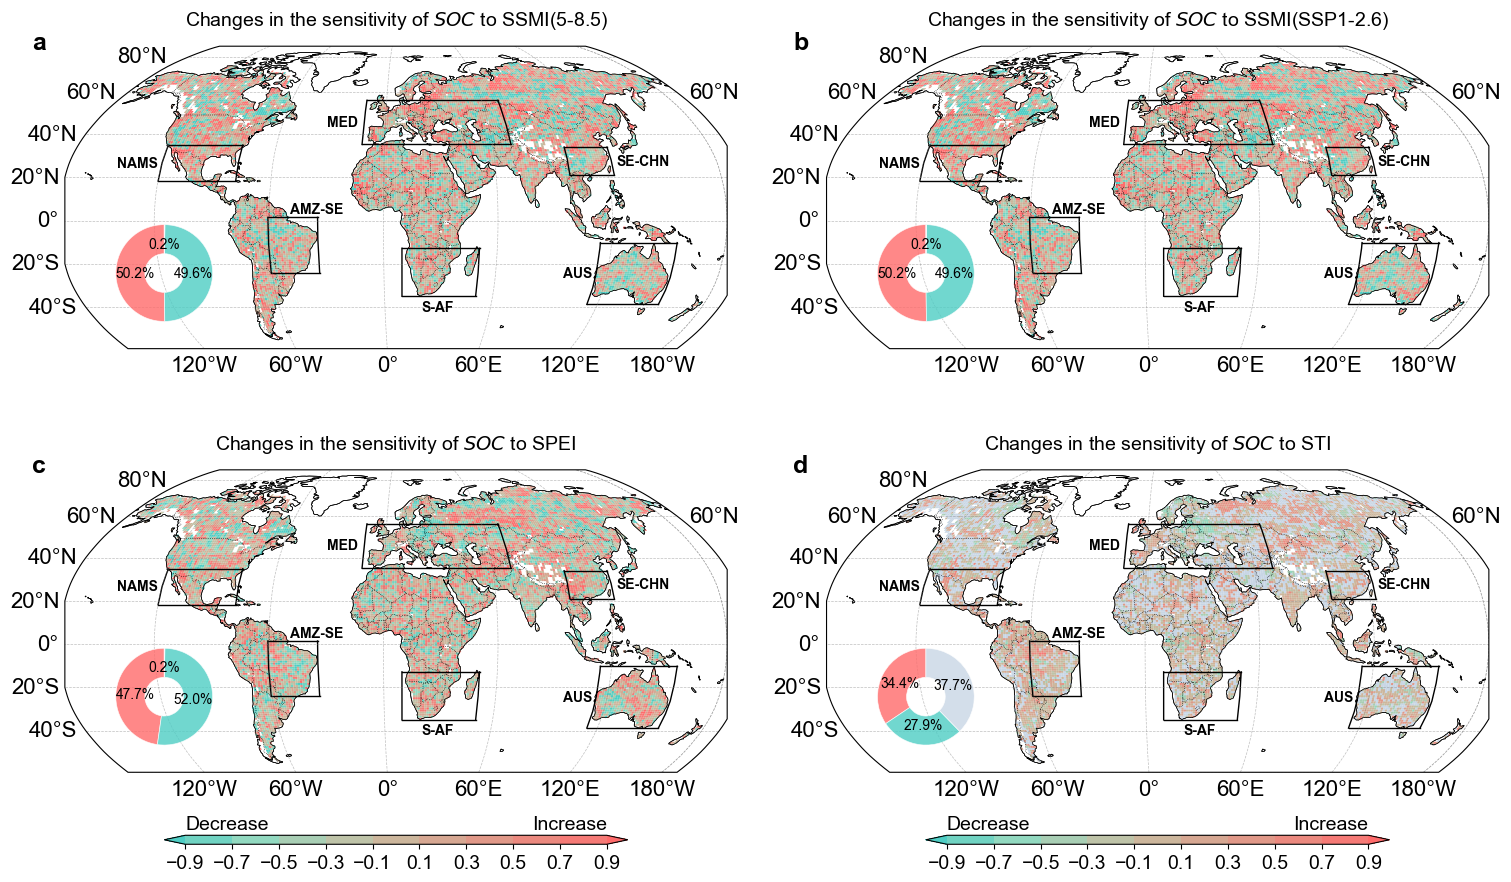

In [12]:
def create_extendedfigure5():
    # 重置matplotlib默认样式，避免全局设置干扰
    plt.rcParams.update(plt.rcParamsDefault)
    # 明确设置子图背景色和边框默认值
    plt.rcParams['axes.facecolor'] = 'white'       # 子图背景白色
    plt.rcParams['axes.edgecolor'] = 'black'       # 边框默认黑色
    plt.rcParams.update({
        'font.family': 'serif',           # 主字体类型（serif衬线 / sans-serif无衬线）
        'font.serif': ['Arial'], # 衬线字体首选
        'font.sans-serif': ['Times New Roman'],      # 无衬线字体备选
    })

    # 创建图形和子图布局
    fig = plt.figure(figsize=(16, 9))

    # 创建2x1的子图布局（根据实际需求调整）
    gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.15, hspace=0.15, top=0.95, bottom=0.07, left=0.1, right=0.99)

    # 第0个子图（图3j）
    ax0 = fig.add_subplot(gs[0], projection=ccrs.Robinson(central_longitude=10))
    mesh0 = plot_extendedfig3j(fig, ax0)

    # 第1个子图（图3a）
    ax1 = fig.add_subplot(gs[1], projection=ccrs.Robinson(central_longitude=10))
    mesh1 = plot_extendedfig3a(fig, ax1)

    # 第2个子图（图3b）
    ax2 = fig.add_subplot(gs[2], projection=ccrs.Robinson(central_longitude=10))
    mesh2 = plot_extendedfig3b(fig, ax2)

    # 第3个子图（图3c）
    ax3 = fig.add_subplot(gs[3], projection=ccrs.Robinson(central_longitude=10))
    mesh3 = plot_extendedfig3c(fig, ax3)

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    create_extendedfigure5()

C:\Users\73433\AppData\Local\Temp\ipykernel_36372\2443326526.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


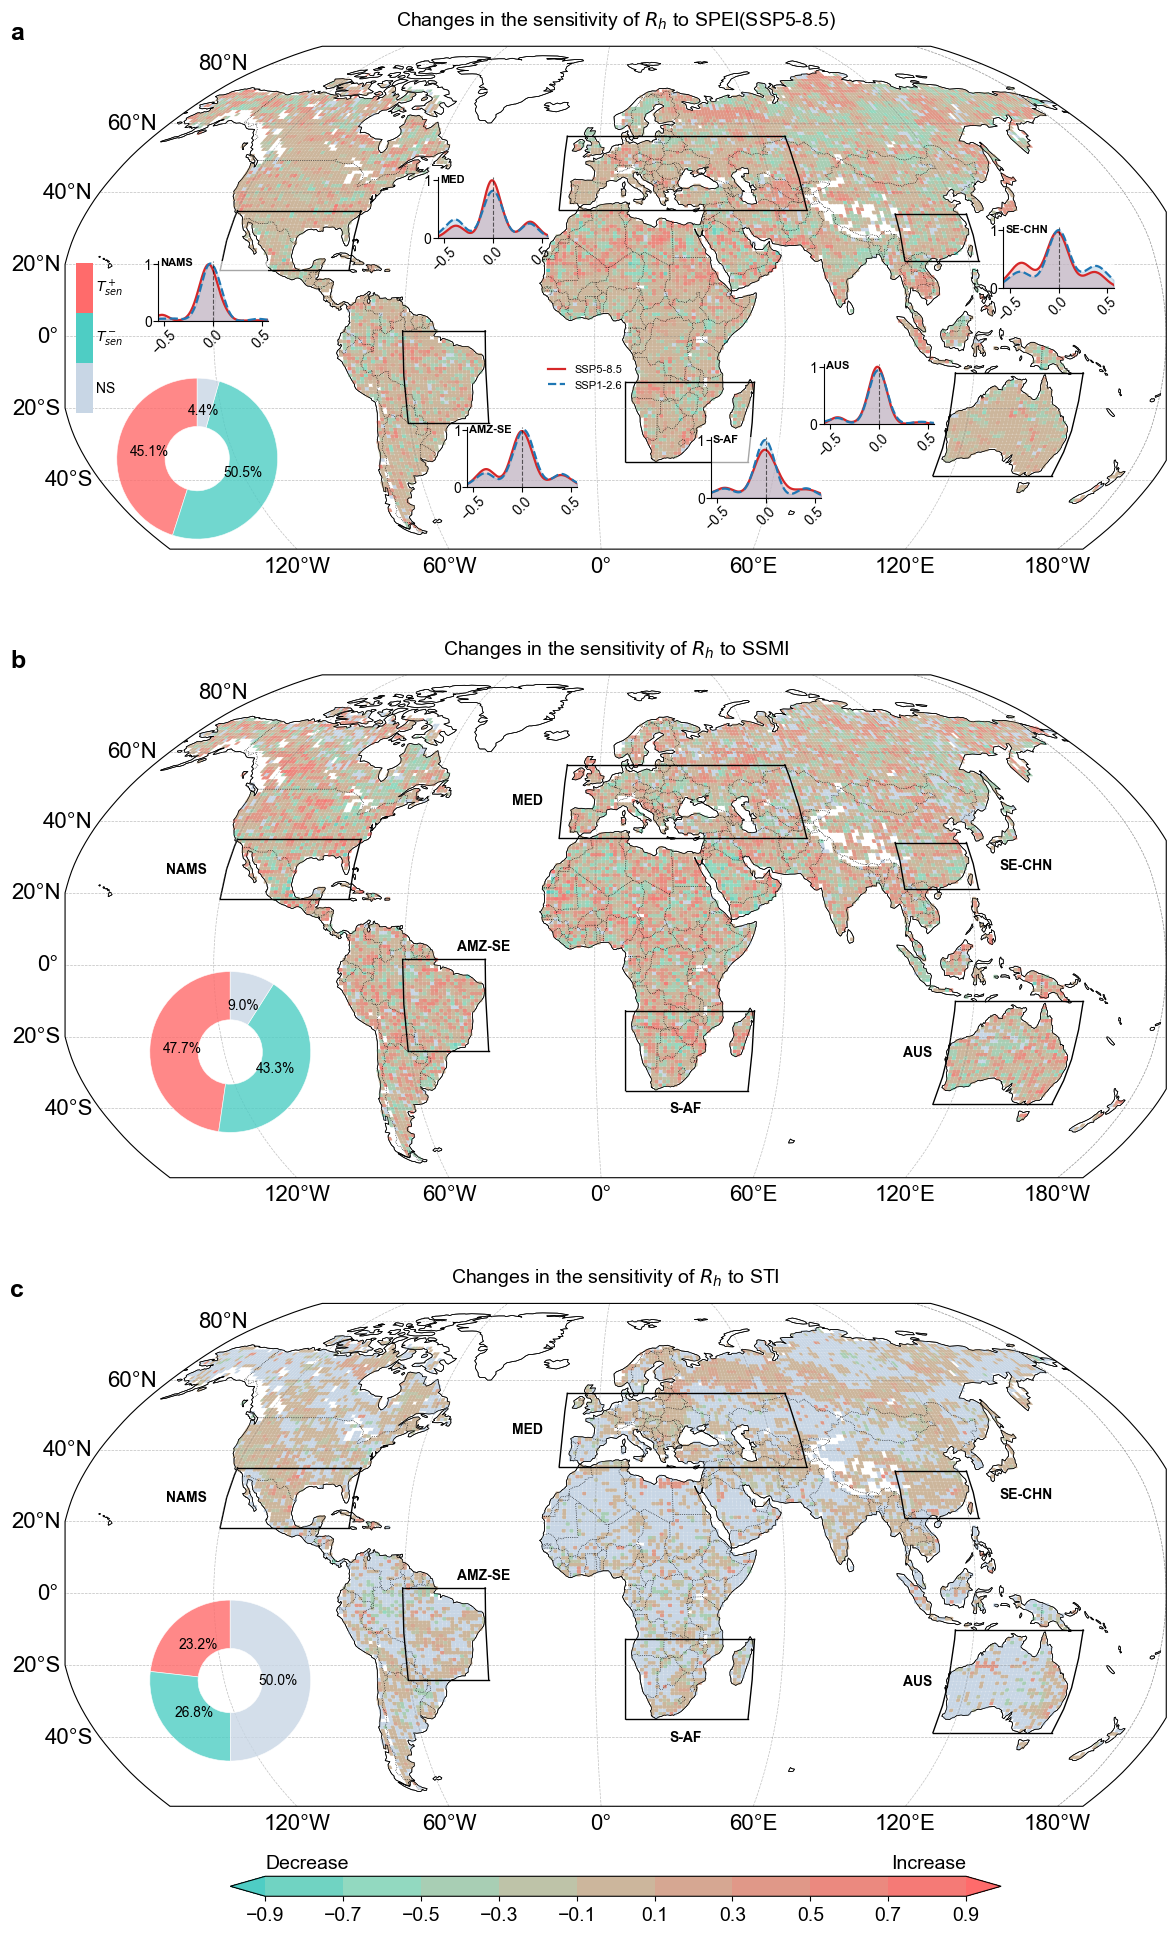

In [13]:
def create_extendedfigure6():
    # 重置matplotlib默认样式，避免全局设置干扰
    plt.rcParams.update(plt.rcParamsDefault)
    # 明确设置子图背景色和边框默认值
    plt.rcParams['axes.facecolor'] = 'white'       # 子图背景白色
    plt.rcParams['axes.edgecolor'] = 'black'       # 边框默认黑色
    plt.rcParams.update({
        'font.family': 'serif',           # 主字体类型（serif衬线 / sans-serif无衬线）
        'font.serif': ['Arial'], # 衬线字体首选
        'font.sans-serif': ['Times New Roman'],      # 无衬线字体备选
    })

    # 创建图形和子图布局
    fig = plt.figure(figsize=(16, 20))

    # 创建2x1的子图布局（根据实际需求调整）
    gs = gridspec.GridSpec(3, 1, figure=fig, wspace=0.15, hspace=0.25, top=0.95, bottom=0.07, left=0.1, right=0.99)

    # 第4个子图（图3d）
    ax4 = fig.add_subplot(gs[0], projection=ccrs.Robinson(central_longitude=10))
    mesh4 = plot_extendedfig3d(fig, ax4)

    # 第5个子图（图3e）
    ax5 = fig.add_subplot(gs[1], projection=ccrs.Robinson(central_longitude=10))
    mesh5 = plot_extendedfig3e(fig, ax5)

    # 第6个子图（图3f）
    ax6 = fig.add_subplot(gs[2], projection=ccrs.Robinson(central_longitude=10))
    mesh6 = plot_extendedfig3f(fig, ax6)

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    create_extendedfigure6()

C:\Users\73433\AppData\Local\Temp\ipykernel_36372\3512836377.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


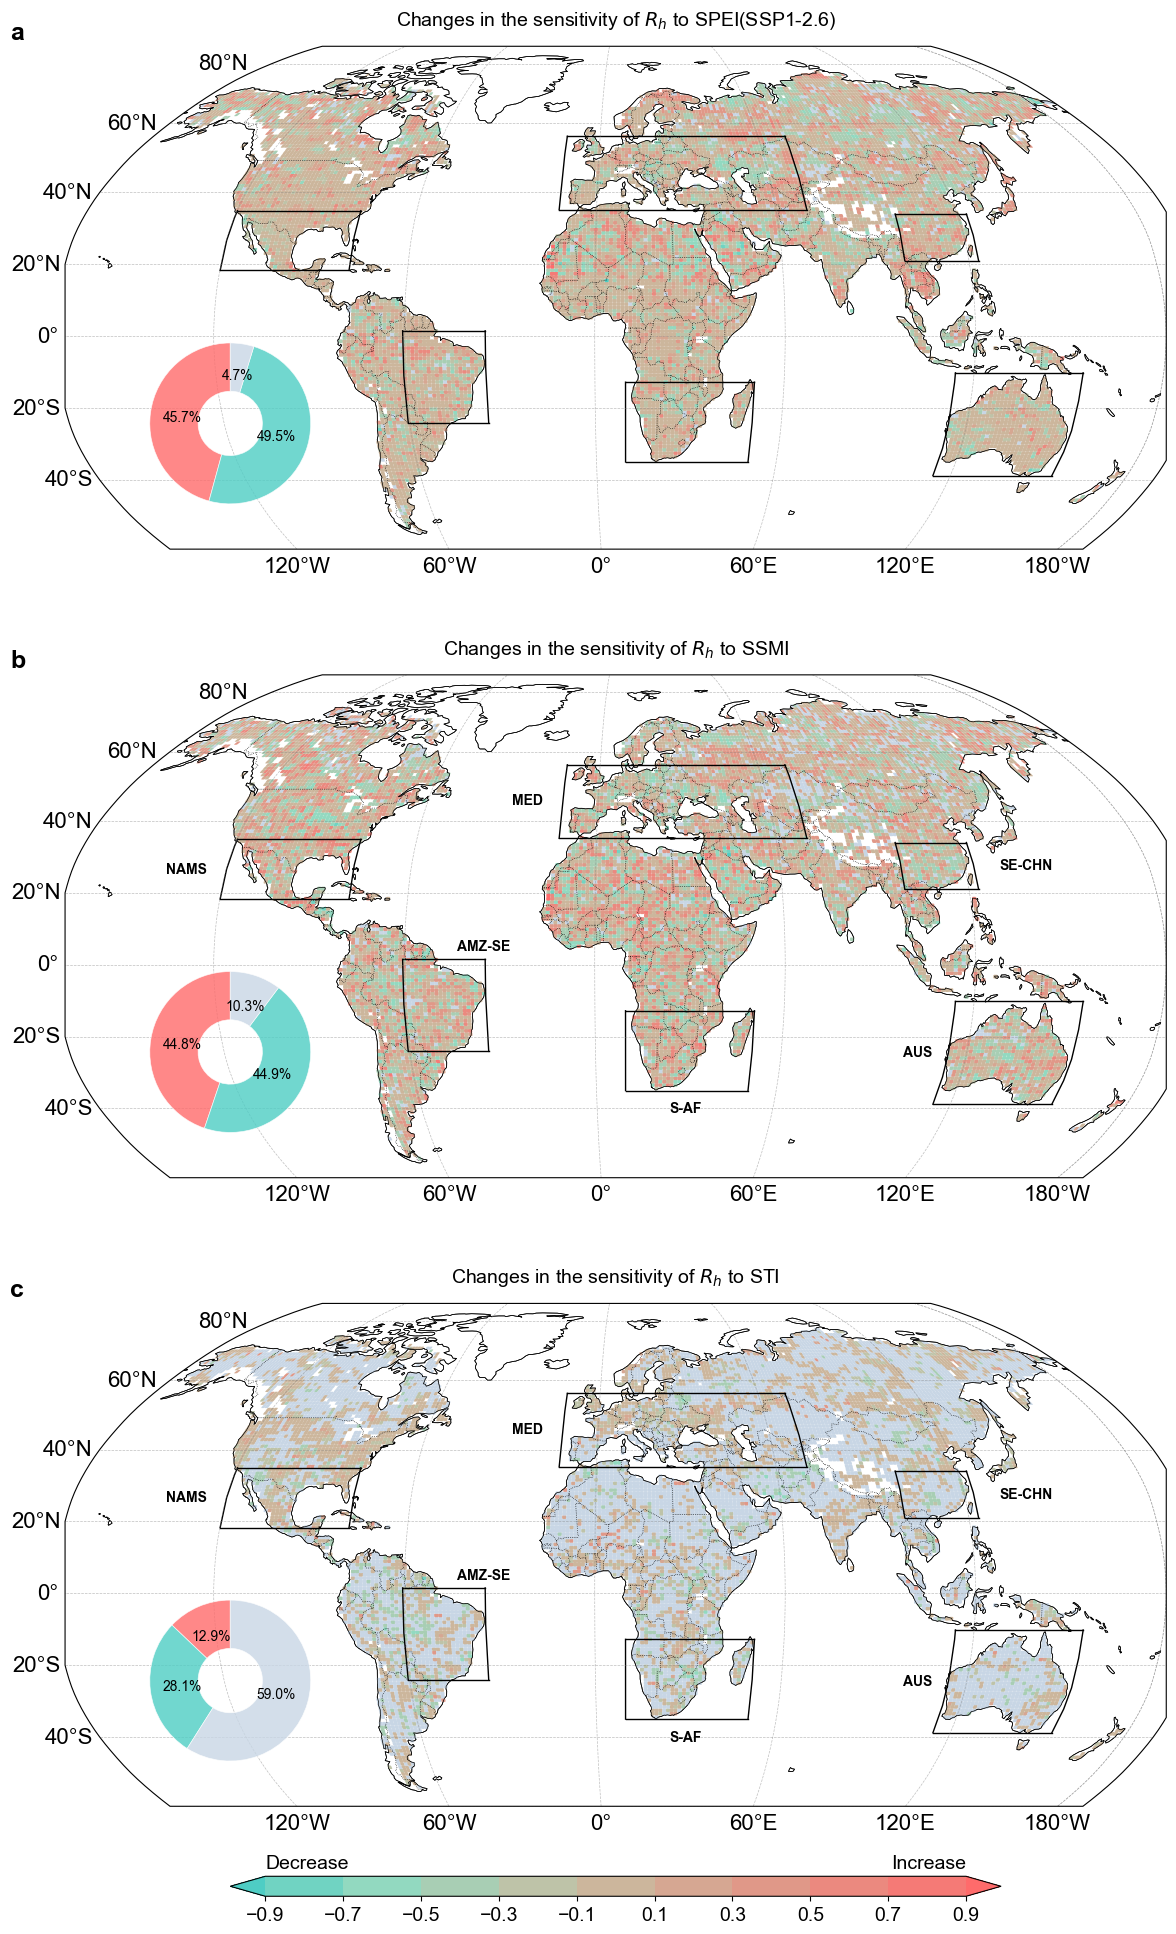

In [14]:
def create_extendedfigure7():
    # 重置matplotlib默认样式，避免全局设置干扰
    plt.rcParams.update(plt.rcParamsDefault)
    # 明确设置子图背景色和边框默认值
    plt.rcParams['axes.facecolor'] = 'white'       # 子图背景白色
    plt.rcParams['axes.edgecolor'] = 'black'       # 边框默认黑色
    plt.rcParams.update({
        'font.family': 'serif',           # 主字体类型（serif衬线 / sans-serif无衬线）
        'font.serif': ['Arial'], # 衬线字体首选
        'font.sans-serif': ['Times New Roman'],      # 无衬线字体备选
    })

    # 创建图形和子图布局
    fig = plt.figure(figsize=(16, 20))

    # 创建2x1的子图布局（根据实际需求调整）
    gs = gridspec.GridSpec(3, 1, figure=fig, wspace=0.15, hspace=0.25, top=0.95, bottom=0.07, left=0.1, right=0.99)

    # 第7个子图（图3g）
    ax7 = fig.add_subplot(gs[0], projection=ccrs.Robinson(central_longitude=10))
    mesh7 = plot_extendedfig3g(fig, ax7)

    # 第8个子图（图3h）
    ax8 = fig.add_subplot(gs[1], projection=ccrs.Robinson(central_longitude=10))
    mesh8 = plot_extendedfig3h(fig, ax8)

    # 第9个子图（图3i）
    ax9 = fig.add_subplot(gs[2], projection=ccrs.Robinson(central_longitude=10))
    mesh9 = plot_extendedfig3i(fig, ax9)

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    create_extendedfigure7()